Lego recently announced the release of an extreme large (more than 9,000 pieces, roughly 4.5 ft long) [model of the Titanic](https://www.lego.com/en-us/product/lego-titanic-10294) (10294) priced at $629.99.

<center><blockquote class="twitter-tweet"><p lang="en" dir="ltr">9,090 pieces. 1.3 meters long (4 ft. 5 in). One LEGO Titanic building project! <a href="https://t.co/guhn2isu17">https://t.co/guhn2isu17</a> <a href="https://t.co/jszY6C4MtC">pic.twitter.com/jszY6C4MtC</a></p>&mdash; LEGO (@LEGO_Group) <a href="https://twitter.com/LEGO_Group/status/1446113247342383110?ref_src=twsrc%5Etfw">October 7, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script></center>

<center><img alt="Lego model of the Titanic (10294)" src="https://www.lego.com/cdn/cs/set/assets/bltb94632aeb971eb91/10294.jpg?fit=bounds&format=jpg&quality=80&width=600&height=600&dpr=1"></center>

Readers of this blog will know that I have written a series of posts ([1](https://austinrochford.com/posts/2021-06-03-vader-meditation.html) [2](https://austinrochford.com/posts/2021-06-10-lego-pymc3.html) [3](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html)) analyzing the factors that drive Lego prices, from the year a set was released to its piece count, theme, and subtheme.  The impending release of the Titanic offers an excellent opportunity to use the model from the [most recent post](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html) in this series to examine the prices of the sets with the largest number of pieces.

First we make the necessary Python imports and do a bit of housekeeping.

In [1]:
%matplotlib inline

In [2]:
import datetime
from functools import reduce

In [3]:
from aesara import shared, tensor as at
import arviz as az
from matplotlib import MatplotlibDeprecationWarning, pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xarray as xr

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [4]:
FIGSIZE = (8, 6)

plt.rcParams['figure.figsize'] = FIGSIZE
sns.set(color_codes=True)

dollar_formatter = StrMethodFormatter("${x:,.0f}")

## Load the Data

We begin the real work by loading the data scraped from Brickset. See the [first post](https://austinrochford.com/posts/2021-06-03-vader-meditation.html) in this series for more background on the data.

In [5]:
DATA_URL = 'https://austinrochford.com/resources/lego/brickset_19800101_20211098.csv.gz'

In [6]:
def to_datetime(year):
    return np.datetime64(f"{round(year)}-01-01")

In [7]:
COLS = [
    "Year released", "Set number",
    "Name", "Set type", "Theme", "Subtheme",
    "Pieces", "RRP$"
]

In [8]:
full_df = (pd.read_csv(DATA_URL, usecols=COLS)
             .dropna(subset=set(COLS) - {"Subtheme"}))
full_df["Year released"] = full_df["Year released"].apply(to_datetime)
full_df = (full_df.sort_values(["Year released", "Set number"])
                  .set_index("Set number"))

In [9]:
full_df.head()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$
Set number,,,,,,,
1041-2,Educational Duplo Building Set,Normal,Dacta,1980-01-01,68.0,NaN,36.50
1075-1,LEGO People Supplementary Set,Normal,Dacta,1980-01-01,304.0,NaN,14.50
1101-1,Replacement 4.5V Motor,Normal,Service Packs,1980-01-01,1.0,NaN,5.65
1123-1,Ball and Socket Couplings & One Articulated Joint,Normal,Service Packs,1980-01-01,8.0,NaN,16.00
1130-1,Plastic Folder for Building Instructions,Normal,Service Packs,1980-01-01,1.0,NaN,14.00


In [10]:
full_df.tail()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$
Set number,,,,,,,
80025-1,Sandy's Power Loader Mech,Normal,Monkie Kid,2021-01-01,520.0,Season 2,54.99
80026-1,Pigsy's Noodle Tank,Normal,Monkie Kid,2021-01-01,662.0,Season 2,59.99
80028-1,The Bone Demon,Normal,Monkie Kid,2021-01-01,1375.0,Season 2,119.99
80106-1,Story of Nian,Normal,Seasonal,2021-01-01,1067.0,Chinese Traditional Festivals,79.99
80107-1,Spring Lantern Festival,Normal,Seasonal,2021-01-01,1793.0,Chinese Traditional Festivals,119.99


In [11]:
full_df.describe()

,Pieces,RRP$
count,8636.000000,8636.000000
mean,265.029180,31.741934
std,500.511219,46.129177
min,0.000000,0.000000
25%,32.000000,7.000000
50%,100.000000,18.000000
75%,305.000000,39.990000
max,11695.000000,799.990000


We now add a column `RRP2021`, which is `RRP$` adjusted to 2021 dollars.

In [12]:
CPI_URL = 'https://austinrochford.com/resources/lego/CPIAUCNS202100401.csv'

In [13]:
years = pd.date_range('1979-01-01', '2021-01-01', freq='Y') \
            + datetime.timedelta(days=1)
cpi_df = (pd.read_csv(CPI_URL, index_col="DATE", parse_dates=["DATE"])
            .loc[years])
cpi_df["to2021"] = cpi_df.loc["2021-01-01"] / cpi_df

In [14]:
full_df["RRP2021"] = (pd.merge(full_df, cpi_df,
                               left_on=["Year released"],
                               right_index=True)
                        .apply(lambda df: df["RRP$"] * df["to2021"],
                               axis=1))

Based on the exploratory data analysis in the first post in this series, we filter `full_df` down to approximately 6,400 sets to be included in our analysis.

In [15]:
FILTERS = [
    full_df["Set type"] == "Normal",
    full_df["Pieces"] > 10,
    full_df["Theme"] != "Duplo",
    full_df["Theme"] != "Service Packs",
    full_df["Theme"] != "Bulk Bricks",
    full_df["RRP2021"] > 0
]

In [16]:
df = full_df[reduce(np.logical_and, FILTERS)].copy()

In [17]:
df.head()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$,RRP2021
Set number,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,Dacta,1980-01-01,68.0,NaN,36.50,122.721632
1075-1,LEGO People Supplementary Set,Normal,Dacta,1980-01-01,304.0,NaN,14.50,48.752429
5233-1,Bedroom,Normal,Homemaker,1980-01-01,26.0,NaN,4.50,15.130064
6305-1,Trees and Flowers,Normal,Town,1980-01-01,12.0,Accessories,3.75,12.608387
6306-1,Road Signs,Normal,Town,1980-01-01,12.0,Accessories,2.50,8.405591


In [18]:
df.tail()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$,RRP2021
Set number,,,,,,,,
80025-1,Sandy's Power Loader Mech,Normal,Monkie Kid,2021-01-01,520.0,Season 2,54.99,54.99
80026-1,Pigsy's Noodle Tank,Normal,Monkie Kid,2021-01-01,662.0,Season 2,59.99,59.99
80028-1,The Bone Demon,Normal,Monkie Kid,2021-01-01,1375.0,Season 2,119.99,119.99
80106-1,Story of Nian,Normal,Seasonal,2021-01-01,1067.0,Chinese Traditional Festivals,79.99,79.99
80107-1,Spring Lantern Festival,Normal,Seasonal,2021-01-01,1793.0,Chinese Traditional Festivals,119.99,119.99


In [19]:
df.describe()

,Pieces,RRP$,RRP2021
count,6423.000000,6423.000000,6423.000000
mean,345.121283,37.652064,46.267159
std,556.907975,50.917343,59.812083
min,11.000000,0.600000,0.971220
25%,69.000000,9.990000,11.896044
50%,181.000000,19.990000,27.420158
75%,404.000000,49.990000,56.497192
max,11695.000000,799.990000,897.373477


## Modeling

We will reuse the final model from the [previous post](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html).  It includes a time-varying component along with random slopes and intercepts that vary according to the the theme and subtheme of the set in question.

First we create our feature vector (standardized log piece count) and our target vector (log RRP in 2021 dollars).

In [20]:
pieces = df["Pieces"].values
log_pieces = np.log(df["Pieces"].values)

scaler = StandardScaler().fit(log_pieces[:, np.newaxis])

def scale_log_pieces(log_pieces, scaler=scaler):
    return scaler.transform(log_pieces[:, np.newaxis])[:, 0]

std_log_pieces = scale_log_pieces(log_pieces)

In [21]:
rrp2021 = df["RRP2021"].values
log_rrp2021 = np.log(rrp2021)

Next we build indicator variables for the themes and subthemes.

In [22]:
theme_id, theme_map = df["Theme"].factorize(sort=True)

theme_mean_std_log_pieces = (pd.Series(std_log_pieces, index=df.index)
                               .groupby(df["Theme"])
                               .mean())

In [23]:
sub_id, sub_map = df["Subtheme"].factorize(sort=True)
n_sub = sub_map.size

sub_isnull = sub_id == -1

sub_mean_std_log_pieces = (pd.Series(std_log_pieces, index=df.index)
                             .groupby(df["Subtheme"])
                             .mean())

Finally, we transform the year each set was released into the number of years since 1980, when our data set begins.

In [24]:
year = (df["Year released"]
          .dt.year
          .values)
t = year - year.min()

We now recreate the model as in the previous post.

In [25]:
def hierarchical_normal(name, *, dims, μ=None):
    if μ is None:
        μ = pm.Normal(f"μ_{name}", 0., 2.5)

    Δ = pm.Normal(f"Δ_{name}", 0., 1., dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5)
    
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

def hierarchical_normal_with_mean(name, x_mean, *, dims,
                                  μ=None, mean_name="γ"):
    mean_coef = pm.Normal(f"{mean_name}_{name}", 0., 2.5)
        
    return pm.Deterministic(
        name,
        hierarchical_normal(f"_{name}", dims=dims, μ=μ) \
            + mean_coef * x_mean,
        dims=dims
    )

In [26]:
def gaussian_random_walk(name, *, dims, innov_scale=1.):
    Δ = pm.Normal(f"Δ_{name}", 0., innov_scale,  dims=dims)

    return pm.Deterministic(name, Δ.cumsum(), dims=dims)

In [27]:
coords = {
    "set": df.index.values,
    "sub": sub_map,
    "theme": theme_map,
    "year": np.unique(year)
}

First we specify the components of the intercept.

In [28]:
with pm.Model(coords=coords) as model:
    β0_0 = pm.Normal("β0_0", 0., 2.5)
    β0_t = gaussian_random_walk("β0_t", dims="year",
                                innov_scale=0.1)
    
    β0_theme = hierarchical_normal_with_mean(
        "β0_theme",
        theme_mean_std_log_pieces.values,
        dims="theme", μ=0.
    )
    
    β0_sub_null = pm.Normal("β0_sub_null", 0., 2.5)
    β0_sub_nn = hierarchical_normal_with_mean(
        "β0_sub_nn",
        sub_mean_std_log_pieces.values,
        dims="sub", μ=0., mean_name="λ"
    )
    β0_sub_i = at.switch(
        sub_isnull,
        β0_sub_null,
        β0_sub_nn[at.clip(sub_id, 0, n_sub)]
    )
    
    β0_i = β0_0 + β0_t[t] + β0_theme[theme_id] + β0_sub_i

We specify the components of the slope for the (standardized log) number of pieces in the set analagously.

In [29]:
with model:
    β_pieces_0 = pm.Normal("β_pieces_0", 0., 2.5)
    
    β_pieces_theme = hierarchical_normal_with_mean(
        "β_pieces_theme",
        theme_mean_std_log_pieces.values,
        dims="theme", μ=0.
    )
    
    β_pieces_sub_null = pm.Normal("β_pieces_sub_null", 0., 2.5)
    β_pieces_sub_nn = hierarchical_normal_with_mean(
        "β_pieces_sub_nn",
        sub_mean_std_log_pieces.values,
        dims="sub", μ=0., mean_name="λ"
    )
    β_pieces_sub_i = at.switch(
        sub_isnull,
        β_pieces_sub_null,
        β_pieces_sub_nn[at.clip(sub_id, 0, n_sub)]
    )

    β_pieces_i = β_pieces_0 + β_pieces_theme[theme_id] + β_pieces_sub_i

Finally we specify the observational likelihood.

In [30]:
with model:
    σ = pm.HalfNormal("σ", 5.)
    μ = β0_i + β_pieces_i * std_log_pieces - 0.5 * σ**2
    
    obs = pm.Normal("obs", μ, σ, dims="set",
                    observed=log_rrp2021)

We are now ready to sample from the posterior distribution of this model.

In [31]:
CHAINS = 3
SEED = 123456789

SAMPLE_KWARGS = {
    'cores': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)],
    'return_inferencedata': True
}

In [32]:
with model:
    trace = pm.sample(**SAMPLE_KWARGS)
    pp_trace = pm.to_inference_data(
        posterior_predictive=pm.sample_posterior_predictive(trace)
    )

trace.extend(pp_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β0_0, Δ_β0_t, γ_β0_theme, Δ__β0_theme, σ__β0_theme, β0_sub_null, λ_β0_sub_nn, Δ__β0_sub_nn, σ__β0_sub_nn, β_pieces_0, γ_β_pieces_theme, Δ__β_pieces_theme, σ__β_pieces_theme, β_pieces_sub_null, λ_β_pieces_sub_nn, Δ__β_pieces_sub_nn, σ__β_pieces_sub_nn, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1036 seconds.
The number of effective samples is smaller than 10% for some parameters.


Standard sampling diangostics show no cause for concern.

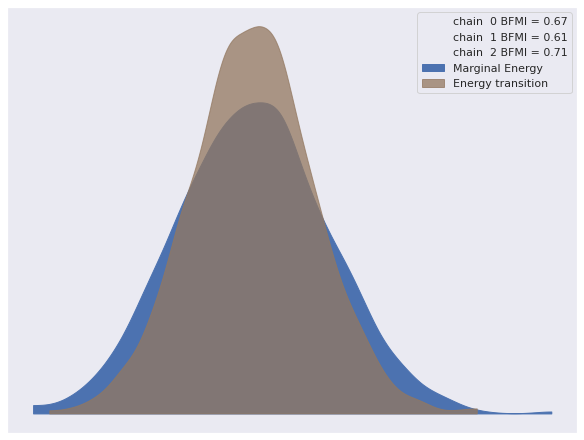

In [33]:
az.plot_energy(trace);

In [34]:
print(az.rhat(trace)
        .max()
        .to_array()
        .max())

<xarray.DataArray ()>
array(1.01564337)


## Analysis

Now that we have sampled from the posterior distribution of the model, we are finally prepared to analyze and interpret the pricing of the sets with the largest number of pieces.  First we select the twenty sets with the largest piece count for closer inspection.

In [35]:
N_TOP = 20

top_by_pieces = df.nlargest(N_TOP, "Pieces")

We examine the posterior predictive distributions of each of these set's price compared to its actual recommended retail price below.

In [36]:
def make_set_label(row):
    name = row["Name"]
    set_number, _ = row.name.split('-', 1)
    pieces = int(row["Pieces"])
    
    return f"{name} ({set_number})\n{pieces:,} pieces"

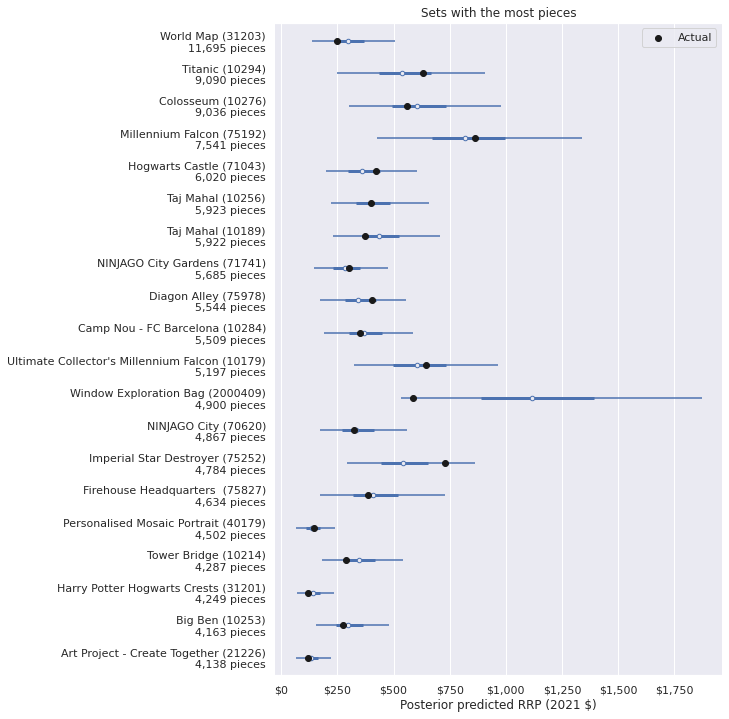

In [37]:
fig, ax = plt.subplots(figsize=(FIGSIZE[0], 2 * FIGSIZE[1]))

az.plot_forest(
    trace.posterior_predictive,
    var_names=["obs"],
    coords={"set": top_by_pieces.index},
    transform=np.exp,
    ax=ax
);
ax.scatter(
    top_by_pieces["RRP2021"][::-1],
    ax.get_yticks(),
    c='k', label="Actual", zorder=5
);

ax.set_yticklabels(
    top_by_pieces.apply(make_set_label, axis=1)[::-1]
);

ax.xaxis.set_major_formatter(dollar_formatter);
ax.set_xlabel("Posterior predicted RRP (2021 $)");

ax.legend();
ax.set_title("Sets with the most pieces");

The first time I drew this plot I was a bit surprised at how well the model predicts the prices for these large sets.  I expected to see larger deviations for sets with an extreme number of pieces (more than about 3,000), so this is a pleasant surprise.  It is worth nothing that while the model's predictions are accurate for most of these large sets, there are a few sets where the actual price are further from the posterior expected value.  These sets are worth focusing on.

In [38]:
FOCUS_SETS = [
    "31203-1",
    "10294-1",
    "71043-1",
    "2000409-1",
    "75252-1",
    "10214-1"
]

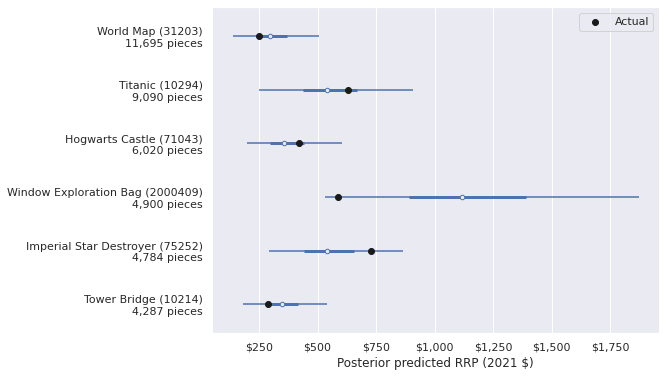

In [39]:
fig, ax = plt.subplots()

az.plot_forest(
    trace.posterior_predictive,
    var_names=["obs"],
    coords={"set": FOCUS_SETS},
    transform=np.exp,
    ax=ax
);
ax.scatter(
    df["RRP2021"]
      .loc[FOCUS_SETS]
      [::-1],
    ax.get_yticks(),
    c='k', label="Actual", zorder=5
);

ax.set_yticklabels(
    df.loc[FOCUS_SETS]
      .apply(make_set_label, axis=1)
      [::-1]
);

ax.xaxis.set_major_formatter(dollar_formatter);
ax.set_xlabel("Posterior predicted RRP (2021 $)");

ax.legend();
ax.set_title(None);

Sets that are priced significantly lower than their posterior expected value tend to have lots of similar small and/or standard pieces.

* The [World Map (31203)](https://www.lego.com/en-gb/product/world-map-31203) contains thousands of small dots.

<center><img alt="Lego World Map (31203)" src="https://www.lego.com/cdn/cs/set/assets/blt6e4605758d75ce41/31203.jpg?fit=bounds&format=jpg&quality=80&width=600&height=600&dpr=1"></center>

* The [Window Exploration Bag (2000409)](https://www.lego.com/en-us/product/window-exploration-bag-2000409) contains thousands of fairly standard bricks.  (I had never heard of Lego's ["Serious Play"](https://www.lego.com/en-us/seriousplay) method before, and it is interesting and may merit a post of its own.)

<center><img alt="Lego Window Exploration Bag (2000409)" src="https://www.lego.com/cdn/cs/set/assets/bltf952785f84bbefa6/2000409.jpg?fit=bounds&format=jpg&quality=80&width=600&height=600&dpr=1"></center>

* [Tower Bridge (10214)](https://www.lego.com/en-us/product/tower-bridge-10214) conforms to this explanation slightly less well, but there are still large repetitive portions (turrets, bridge suspension cables) that require many fairly standard pieces.

<center><img alt="Lego Tower Bridge (10214)" src="https://www.lego.com/cdn/cs/set/assets/bltc4f19e085e17bcea/10214.jpg?fit=bounds&format=jpg&quality=80&width=600&height=600&dpr=1"></center>

In light of these similarities for large sets that are underpriced relative to our predictions, it makes sense to consider including information about the pieces included in the set (and the quantity of each piece that is included) in a future model.  I have not scraped this data about the piece composition of each set yet, but it is available from [Brickset](https://brickset.com/) an probably also from [BrickLink](https://bricklink.com).

Sets that are priced significantly higher than their posterior expected value include the Titanic (10294), [Hogwarts Castle (71043)](https://www.lego.com/en-us/product/hogwarts-castle-71043) and the [Ultimate Collector Series Imperial Star Destroyer (75252)](https://www.lego.com/en-us/product/imperial-star-destroyer-75252).  Each of these sets is iconic either on its own (the Titanic) or within the associated media franchies (Harry Potter and Star Wars).  It seems reasonable that Lego may be able to charge a premium on such sets.  Note that this interpretation does not hold true for all sets, as the [Ultimate Collector Series Millenium Falcon (75192)](https://www.lego.com/en-us/product/millennium-falcon-75192) is perhaps even more iconic than the Imperial Star Destroyer.  In this instance, Lego may believe that the recommended retail price of $799.99 is near the maximum that the market will reasonably bear for a Lego set.

We can examine the posterior predictive distribution of some individual sets in more detail.

In [40]:
def format_posterior_artist(artist, formatter):
    text = artist.get_text()
    x, _ = artist.get_position()

    if text.startswith(" ") or text.endswith(" "):
        fmtd_text = formatter(x)
        artist.set_text(
            " " + fmtd_text if text.startswith(" ") else fmtd_text + " "
        )
    elif "=" in text:
        before, _ = text.split("=")
        artist.set_text("=".join((before, formatter(x))))
    elif "<" in text:
        below, ref_val_str, above = text.split("<")
        artist.set_text("<".join((
            below,
            " " + formatter(float(ref_val_str)) + " ",
            above
        )))

def format_posterior_text(formatter, ax=None):
    if ax is None:
        ax = plt.gca()
    
    artists = [artist for artist in ax.get_children() if isinstance(artist, plt.Text)]
    
    for artist in artists:
        format_posterior_artist(artist, formatter)

In [41]:
def plot_set_posterior(set_number, df, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    az.plot_posterior(
        trace, var_names=["obs"],
        group="posterior_predictive",
        coords={"set": f"{set_number}-1"},
        transform=np.exp,
        ref_val=df["RRP2021"].loc[f"{set_number}-1"],
        ax=ax
    )

    format_posterior_text(dollar_formatter, ax=ax)

    ax.set_xlabel("Posterior predicted RRP (2021 $)")
    ax.set_title(f"{df['Name'].loc[set_number + '-1']} ({set_number})")
    
    return ax

As seen above, the Titanic (10294) is a bit overpriced according to our model, but not unreasonably so.

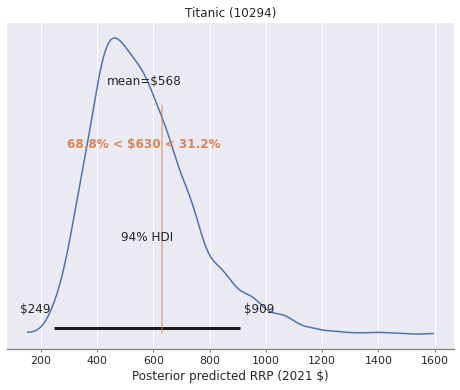

In [42]:
TITANIC_SET_NUMBER = "10294"
plot_set_posterior(TITANIC_SET_NUMBER, df);

We see that the Millenium Falcon (75192) is priced right about in line with the models expectations.

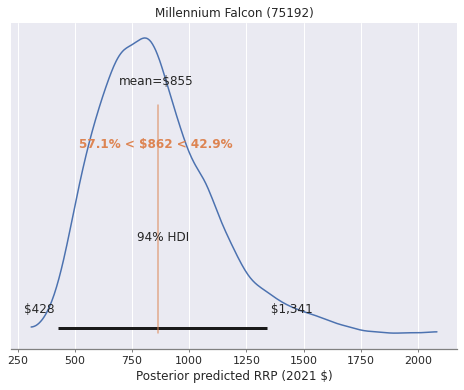

In [43]:
MF_SET_NUMBER = "75192"
plot_set_posterior(MF_SET_NUMBER, df);

I hope this analysis has been as interesting to you as it has to me. I am pleasantly surprised at how well the model predicts set prices even when the number of pieces is extremely large.  While this analysis has not sold me on the Titanic, it adds to my desire to get the Ultimate Collector Series Millenium Falcon and Imperial Star Destroy some day. (Unfortunately?) I have to finish my half-built [Super Star Destroyer (10221)](https://brickset.com/sets/10221-1/Super-Star-Destroyer) first.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/a509641ba402eac9878490cc3de53bb0).

In [44]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Tue Oct 12 2021

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.25.0

arviz     : 0.11.2
seaborn   : 0.11.1
matplotlib: 3.4.2
aesara    : 2.1.3
xarray    : 0.19.0
pymc3     : 4.0
numpy     : 1.19.5
pandas    : 1.3.0

